In [1]:
from __future__ import annotations

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
import nshconfig_extra as CE

import jmp.configs as jc
from jmp.lightning_module import Module

ckpt_path = CE.CachedPath(
    uri="hf://nimashoghi/mptrj-alex-omat24-jmp-s-1our3wgd/checkpoints/last/epoch1-step172332.ckpt"
)


def update_hparams(config):
    config.pretrained_ckpt = CE.CachedPath(uri="/mnt/shared/checkpoints/jmp-s.pt")
    config.energy_referencer = jc.PerAtomReferencerConfig.linear_reference(
        "mptrj-salex"
    )
    return config


# Load the model from the checkpoint
module = Module.load_ckpt(ckpt_path.resolve(), update_hparams).cuda().eval()


Unrecognized arguments:  dict_keys(['ln', 'dropout', 'replace_scale_factors_with_ln', 'learnable_rbf', 'learnable_rbf_stds', 'unique_basis_per_layer', 'old_gaussian_implementation', 'edge_dropout'])


CRITICAL:root:Found the following scale factors: [('int_blocks.0.trip_interaction.scale_rbf', 'int_blocks.0.trip_interaction.scale_rbf'), ('int_blocks.0.trip_interaction.scale_cbf_sum', 'int_blocks.0.trip_interaction.scale_cbf_sum'), ('int_blocks.0.quad_interaction.scale_rbf', 'int_blocks.0.quad_interaction.scale_rbf'), ('int_blocks.0.quad_interaction.scale_cbf', 'int_blocks.0.quad_interaction.scale_cbf'), ('int_blocks.0.quad_interaction.scale_sbf_sum', 'int_blocks.0.quad_interaction.scale_sbf_sum'), ('int_blocks.0.atom_edge_interaction.scale_rbf', 'int_blocks.0.atom_edge_interaction.scale_rbf'), ('int_blocks.0.atom_edge_interaction.scale_cbf_sum', 'int_blocks.0.atom_edge_interaction.scale_cbf_sum'), ('int_blocks.0.edge_atom_interaction.scale_rbf', 'int_blocks.0.edge_atom_interaction.scale_rbf'), ('int_blocks.0.edge_atom_interaction.scale_cbf_sum', 'int_blocks.0.edge_atom_interaction.scale_cbf_sum'), ('int_blocks.0.atom_interaction.scale_rbf_sum', 'int_blocks.0.atom_interaction.scale_r

In [5]:
import datasets

dataset = datasets.load_dataset("nimashoghi/mptrj", split="train", streaming=True)
dataset = dataset.filter(lambda extxyz_id: extxyz_id == 0, input_columns=["extxyz_id"])
dataset_iter = iter(dataset)
dataset

IterableDataset({
    features: Unknown,
    n_shards: 8
})

In [6]:
import torch
from torch_geometric.data import Batch, Data


def new_batch():
    data_dict = next(dataset_iter)
    data = Data.from_dict(
        {
            "pos": torch.tensor(data_dict["positions"], dtype=torch.float),
            "atomic_numbers": (
                atomic_numbers := torch.tensor(data_dict["numbers"], dtype=torch.long)
            ),
            "tags": torch.full_like(atomic_numbers, 2, dtype=torch.long),
            "fixed": torch.zeros_like(atomic_numbers, dtype=torch.bool),
            # "natoms": data_dict["natoms"].long(),
            "natoms": torch.tensor(data_dict["num_atoms"], dtype=torch.long),
            # "cell": data_dict["cell"].view(1, 3, 3),
            "cell": torch.tensor(data_dict["cell"], dtype=torch.float).view(1, 3, 3),
            # "y": data_dict["corrected_total_energy"],
            "energy": torch.tensor(
                data_dict["corrected_total_energy"], dtype=torch.float
            ),
            # "force": data_dict["forces"],
            "force": torch.tensor(data_dict["forces"], dtype=torch.float),
            # "stress": data_dict["stress"].view(1, 3, 3),
            "stress": torch.tensor(data_dict["stress"], dtype=torch.float).view(
                1, 3, 3
            ),
            # "eform": data_dict["ef_per_atom_relaxed"],
            "eform": torch.tensor(data_dict["ef_per_atom_relaxed"], dtype=torch.float),
        }
    )
    batch = Batch.from_data_list([data])
    return batch


In [8]:
from lightning.fabric.utilities.apply_func import move_data_to_device
from tqdm import trange

num_embeddings = 1_000

torch.no_grad().__enter__()

embeddings = []
eforms = []

for i in trange(num_embeddings):
    while True:
        try:
            batch = new_batch()
            embedding = module.embeddings(batch)
            eform = batch.eform

            embedding = move_data_to_device(embedding, "cpu")
            eform = move_data_to_device(eform, "cpu")

            embeddings.append(embedding)
            eforms.append(eform)
            break
        except Exception as e:
            print(e)
            continue


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:33<00:00, 29.67it/s]


In [ ]:
print(torch.stack([embedding["energy"].mean(dim=0) for embedding in embeddings]))


tensor[1000, 256] n=256000 (1.0Mb) x∈[-0.783, 11.089] μ=0.068 σ=0.480


In [ ]:
import numpy as np

embeddings_avg = torch.stack(
    [embedding["energy"].mean(dim=0) for embedding in embeddings]
).numpy()
labels = torch.stack(eforms).numpy()

print(embeddings_avg.shape, labels.shape)

np.save("/mnt/shared/jmp-wbm-embeddings-v2/mptrj/embeddings_avg.npy", embeddings_avg)
np.save("/mnt/shared/jmp-wbm-embeddings-v2/mptrj/labels.npy", labels)


(10000, 256) (10000, 1)


In [27]:
import numpy as np

embeddings_avg = torch.cat([embedding["energy"] for embedding in embeddings])
labels = torch.cat(
    [
        torch.repeat_interleave(eform, embedding["energy"].size(0))
        for eform, embedding in zip(eforms, embeddings)
    ]
)
print(embeddings_avg.shape, labels.shape)

if False:
    # subsmaple 1000 points
    indices = np.random.choice(len(embeddings_avg), 10000, replace=False)
    embeddings_avg = embeddings_avg[indices]
    labels = labels[indices]
    print(embeddings_avg.shape, labels.shape)


torch.Size([27621, 256]) torch.Size([27621])


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

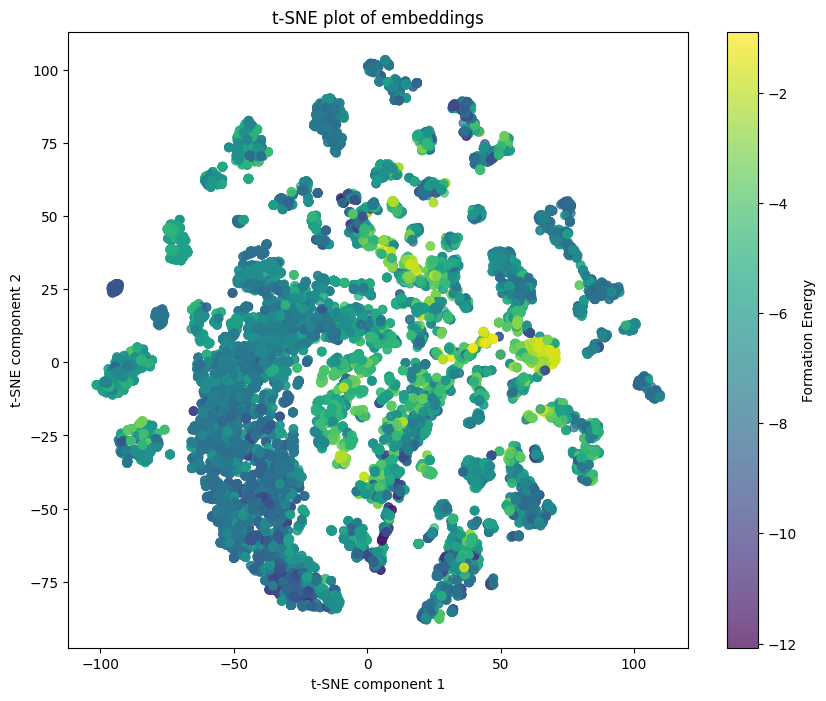

In [28]:
import os

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

os.environ["OMP_NUM_THREADS"] = "1"

# Perform t-SNE on the embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=100)
embeddings_tsne = tsne.fit_transform(embeddings_avg)

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels, cmap="viridis", alpha=0.7
)
plt.colorbar(scatter, label="Formation Energy")
plt.title("t-SNE plot of embeddings")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.show()